##Brain Tumor Detection Model

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob
import re
DATA_DIR = 'lgg-mri-segmentation'
image_path = []
patient_ids = []
masks = []
mask_path = glob(DATA_DIR + '*/*_mask*')

for i in mask_path:
    image_path.append(i.replace('_mask',''))
    patient_ids.append(i[i.find(len('lgg-mri-segmentation/'):i.rfind('/TCGA')])
    if (cv2.imread(i).max() == 0):
      mask = 0
    else:
      mask = 1
    masks.append(mask)

data = {'patient_id': patient_ids, 'image_path': image_path, 'mask_path': mask_path, 'mask':masks}
brain_df = pd.DataFrame(data)
brain_df.head()

In [ ]:
brain_df = pd.read_csv('lgg-mri-segmentation/data_mask.csv')

In [ ]:
brain_df.mask_path[3]

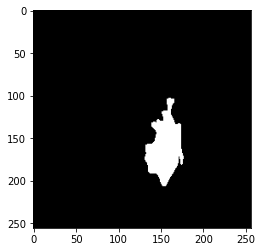

In [ ]:
plt.imshow(cv2.imread(brain_df.mask_path[3]))

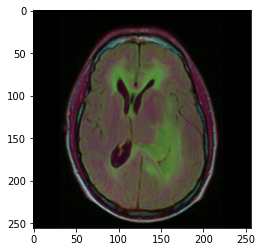

In [ ]:
plt.imshow(cv2.imread(brain_df.image_path[3]))

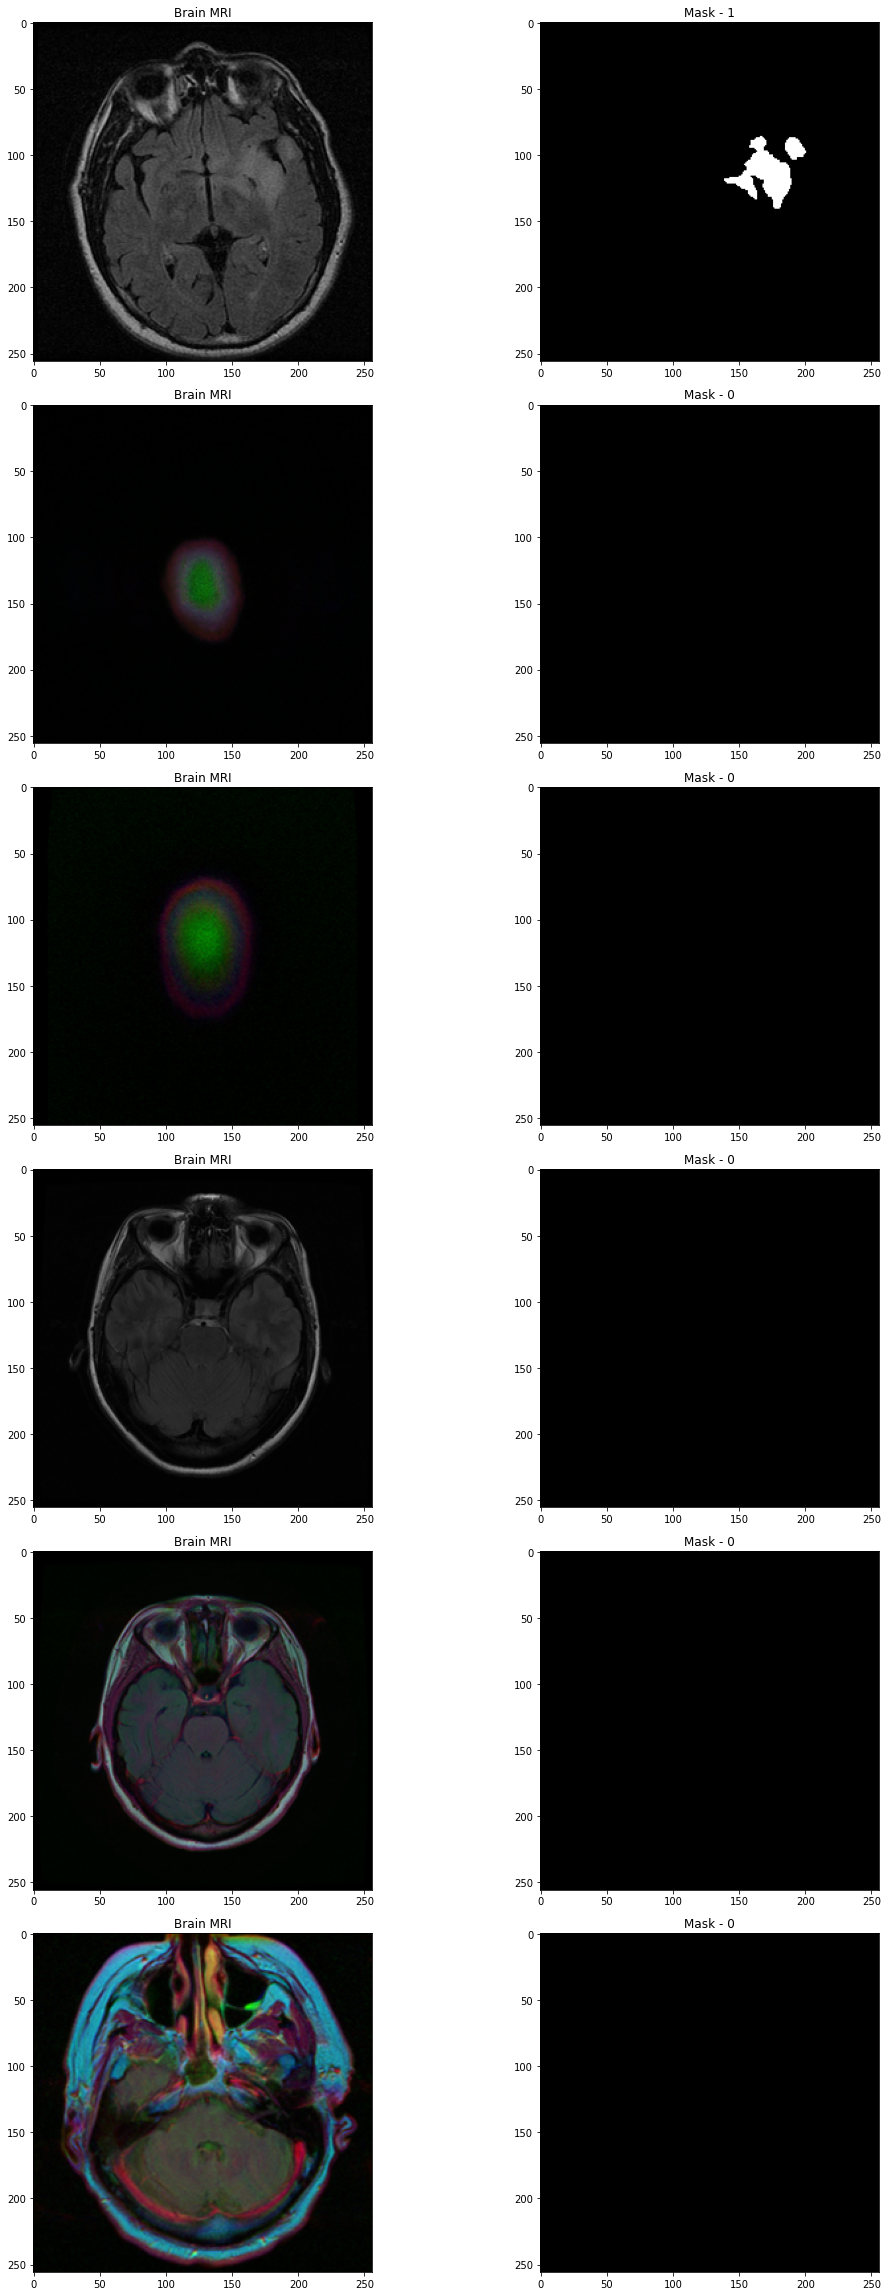

In [ ]:
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

In [ ]:
brain_df.to_csv(r'lgg-mri-segmentation/data_mask.csv')

In [ ]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

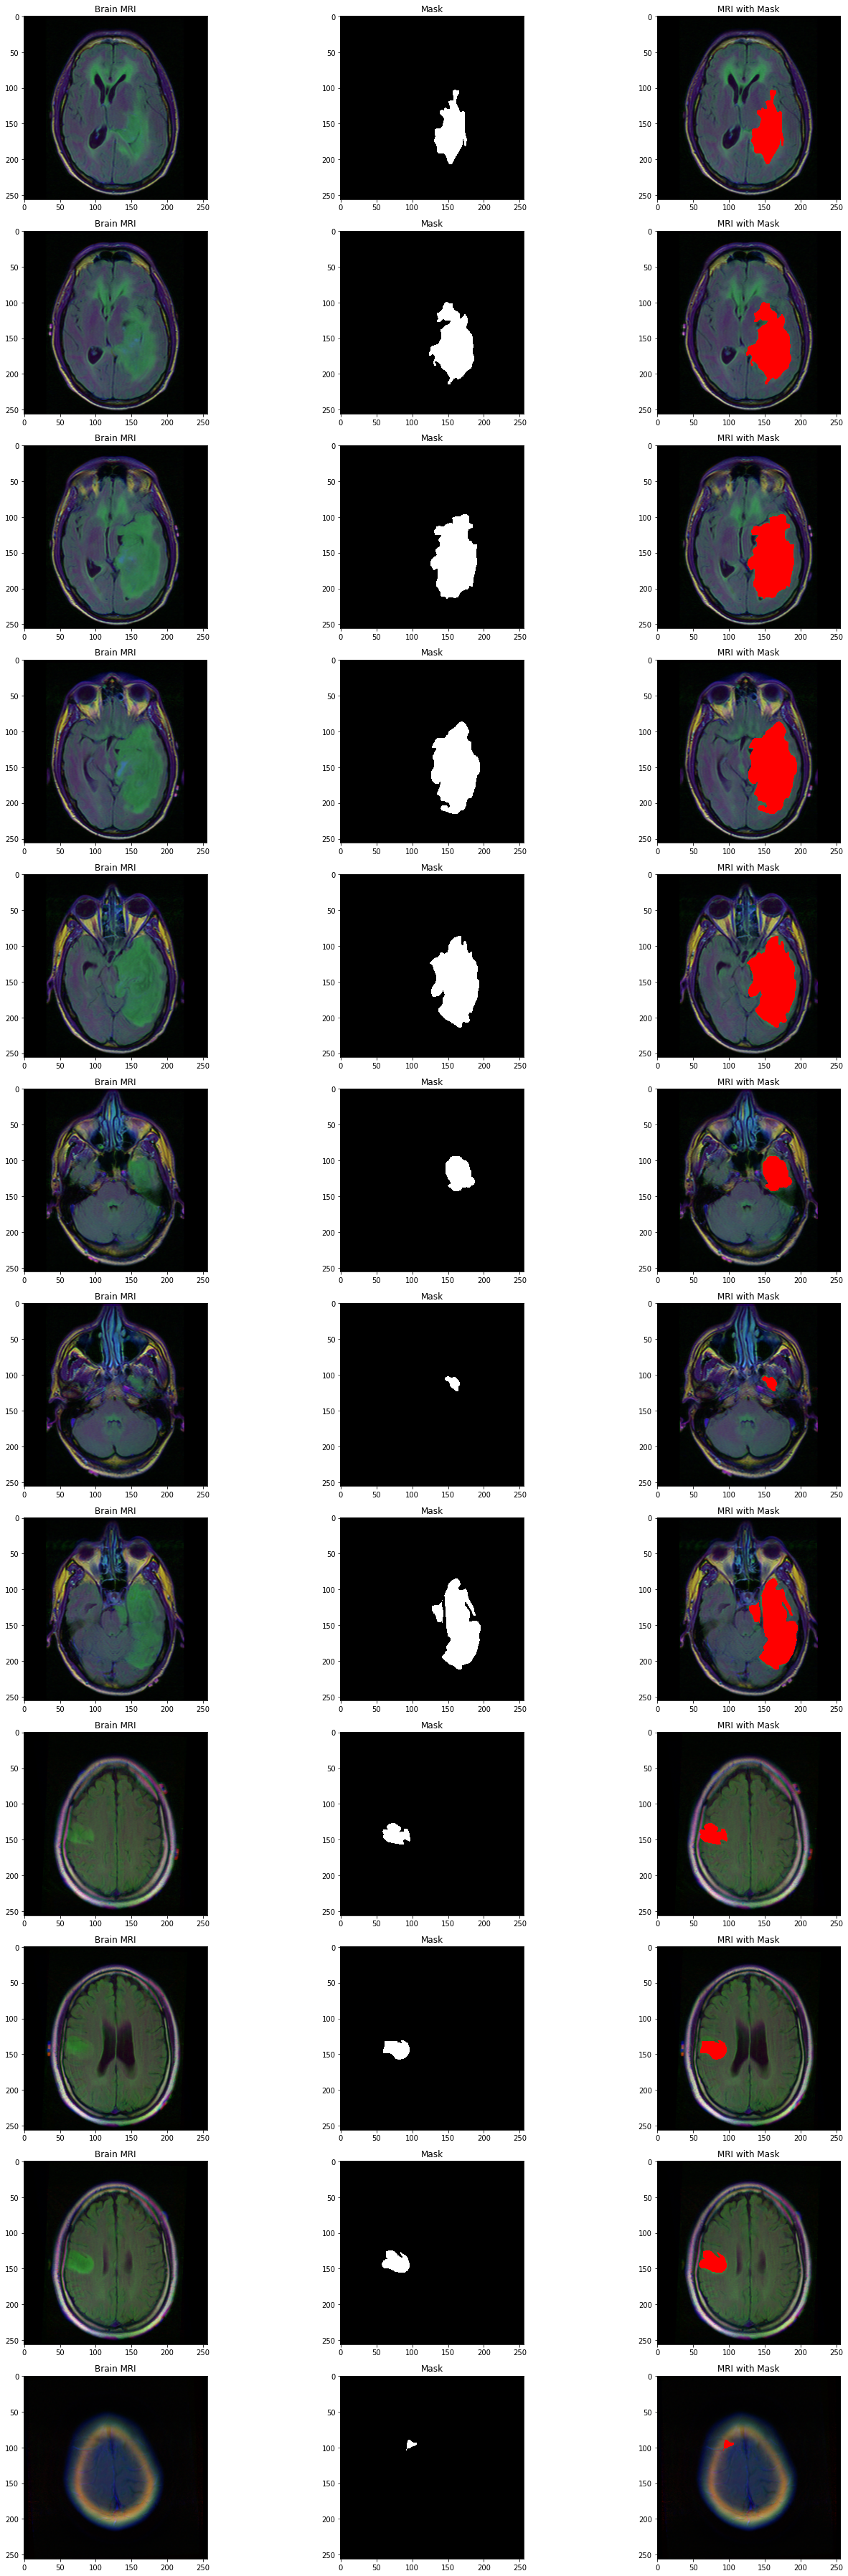

In [ ]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()

In [ ]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3930, 6)

In [ ]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3930 entries, 0 to 3929
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    3930 non-null   int64 
 1   Unnamed: 0.1  3930 non-null   int64 
 2   image_path    3930 non-null   object
 3   mask_path     3930 non-null   object
 4   mask          3930 non-null   object
dtypes: int64(2), object(3)
memory usage: 153.6+ KB


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [ ]:
test['mask'][3275]

'0'

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 501 validated image filenames belonging to 2 classes.
Found 589 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
# Get the ResNet50 base model
if augment_data:
    train_datagen   = ImageDataGenerator(rescale            = 1./255,
                                         rotation_range     = rotation_range,
                                         width_shift_range  = width_shift_range,
                                         height_shift_range = height_shift_range,
                                         shear_range        = shear_range,
                                         brightness_range   = brightness_range,
                                         zoom_range         = zoom_range,
                                         horizontal_flip    = horizontal_flip,
                                         fill_mode          = fill_mode)
else:
    train_datagen   = ImageDataGenerator(rescale = 1./255)

validation_datagen   = ImageDataGenerator(rescale = 1./255)
test_datagen         = ImageDataGenerator(rescale = 1./255)
train_generator      = train_datagen.flow_from_directory(new_training_path, target_size = (target_img_shape_1, target_img_shape_2), batch_size = batch_size, class_mode = "categorical")  
validation_generator = validation_datagen.flow_from_directory(new_validation_path, target_size = (target_img_shape_1, target_img_shape_2), batch_size = batch_size, class_mode = "categorical") 
test_generator       = test_datagen.flow_from_directory(new_test_path,target_size = (target_img_shape_1, target_img_shape_2), batch_size = batch_size, class_mode = "categorical") 

In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# compile the model

model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = DATA_DIR + "classifier-resnet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True)

In [ ]:
history = model.fit(train_generator, 
                    steps_per_epoch= train_generator.n // 16,
                    epochs = 5,
                    validation_data= valid_generator, 
                    validation_steps= valid_generator.n // 16, 
                    callbacks=[checkpointer, earlystopping])

In [ ]:
epochs = 10
model_save_name = 'classifier-resnet-weights.hdf5'
path = F"lgg-mri-segmentation/{model_save_name}"
model.load_weights(path)
history = model.fit(train_generator, 
                    steps_per_epoch= train_generator.n // 16, 
                    epochs = epochs, 
                    validation_data= valid_generator, 
                    validation_steps= valid_generator.n // 16, 
                    callbacks=[checkpointer, earlystopping])

In [ ]:
model_json = model.to_json()
with open("lgg-mri-segmentation/classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
with open('lgg-mri-segmentation/classifier-resnet-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
path = F"lgg-mri-segmentation/classifier-resnet-weights.hdf5"

# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(path)
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
DATA_DIR = 'lgg-mri-segmentation'
predict_path = DATA_DIR + '/predict/'
predict_datagen         = ImageDataGenerator(rescale = 1./255)
predict_generator       = predict_datagen.flow_from_directory(predict_path,target_size = (256, 256)) 
predict = model.predict(predict_generator)
predict

Found 1 images belonging to 1 classes.


array([[0.76066244, 0.23933758]], dtype=float32)

In [ ]:
# make prediction
test_predict = model.predict(test_generator)

In [ ]:
test_predict

array([[0.7606622 , 0.23933779],
       [0.8829912 , 0.11700883],
       [0.9926409 , 0.00735903],
       ...,
       [0.83646834, 0.16353168],
       [0.93712795, 0.06287201],
       [0.9292526 , 0.07074736]], dtype=float32)

In [ ]:
test_predict.shape

(576, 2)

In [ ]:
test_predict

array([[9.5961469e-01, 4.0385347e-02],
       [9.6596789e-01, 3.4032125e-02],
       [9.3625259e-01, 6.3747399e-02],
       ...,
       [1.5466961e-06, 9.9999845e-01],
       [9.3988025e-01, 6.0119770e-02],
       [1.7314662e-07, 9.9999988e-01]], dtype=float32)

In [ ]:
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [ ]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9079861111111112

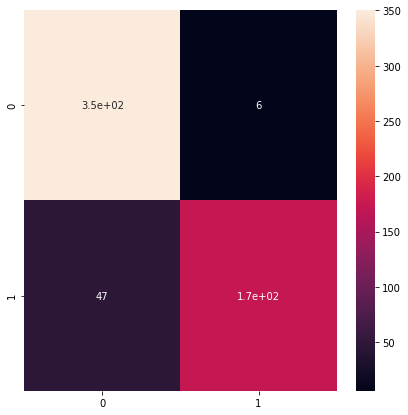

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       356
           1       0.97      0.79      0.87       220

   micro avg       0.91      0.91      0.91       576
   macro avg       0.92      0.88      0.90       576
weighted avg       0.91      0.91      0.91       576



/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:576: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



##Segmentation Model

In [ ]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 7)

In [ ]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [ ]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [ ]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [ ]:
EPOCHS = 150
BATCH_SIZE = 16
learning_rate = 1e-4

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
training_generator = train_generator(X_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(256, 256))
    
validation_generator = train_generator(X_val, BATCH_SIZE,
                                train_generator_args,
                                target_size=(256, 256))
test_generator = train_generator(X_test, BATCH_SIZE,
                                dict(),
                                target_size=(256, 256))

In [ ]:
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [ ]:
model_seg.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
epsilon = 1e-5
smooth = 1

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 

def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)


In [ ]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
DATA_DIR = 'lgg-mri-segmentation/'

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath=DATA_DIR + "ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit(training_generator,
                    steps_per_epoch=len(X_train) / 16, 
                    epochs=EPOCHS, 
                    callbacks=[checkpointer, earlystopping],
                    validation_data = validation_generator,
                    validation_steps=len(X_val) / 16)


In [ ]:
model_save_name = 'ResUNet-weights.hdf5'
path = F"lgg-mri-segmentation/{model_save_name}"
model_seg.load_weights(path)
# history = model.fit(train_generator, 
#                     steps_per_epoch= train_generator.n // 16, 
#                     epochs = epochs, 
#                     validation_data= valid_generator, 
#                     validation_steps= valid_generator.n // 16, 
#                     callbacks=[checkpointer, earlystopping])

In [ ]:
model_json = model_seg.to_json()
with open(DATA_DIR + "ResUNet-MRI.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
with open(DATA_DIR + 'ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights(DATA_DIR + 'ResUNet-weights.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
model_seg.save(DATA_DIR + "/model")

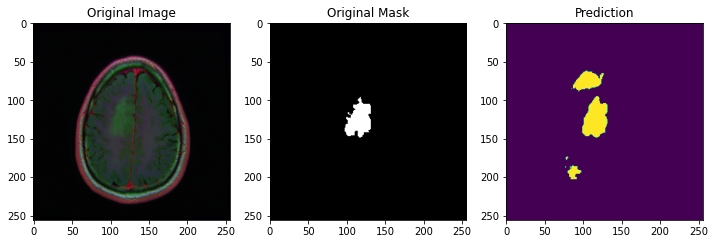

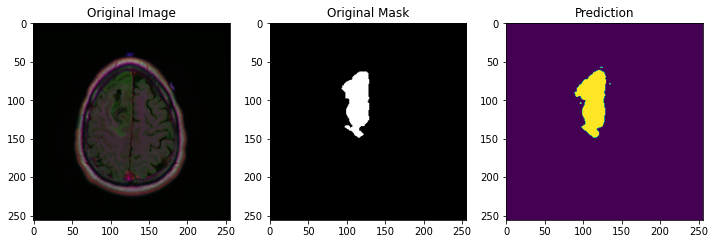

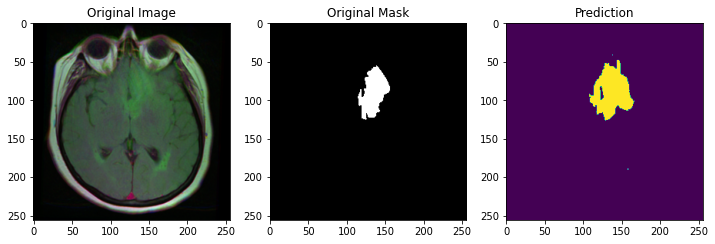

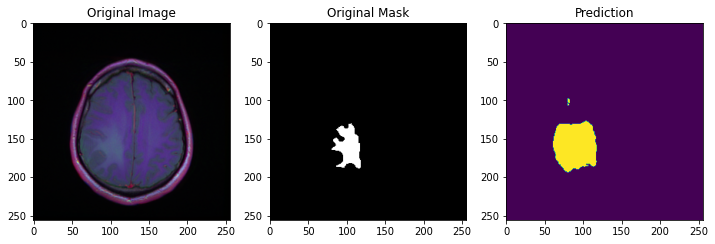

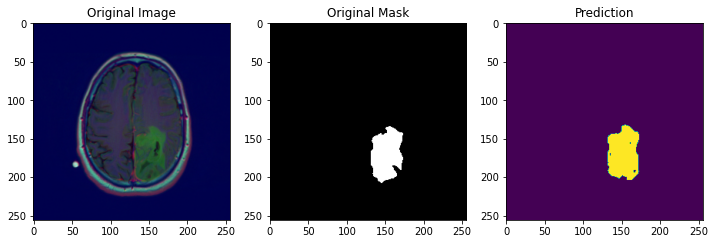

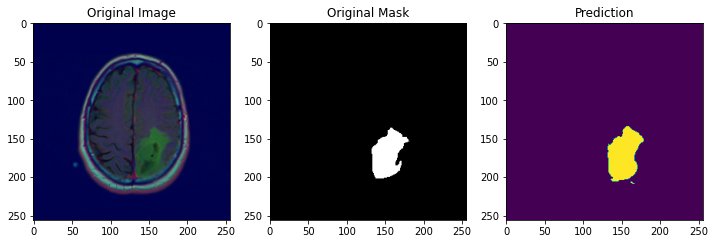

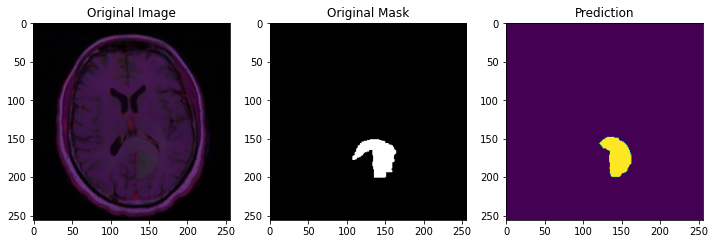

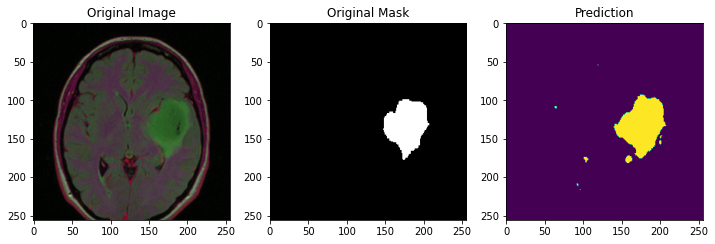

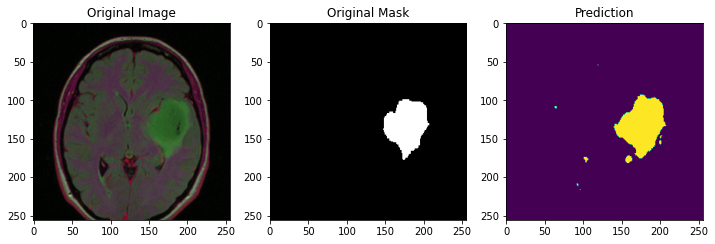

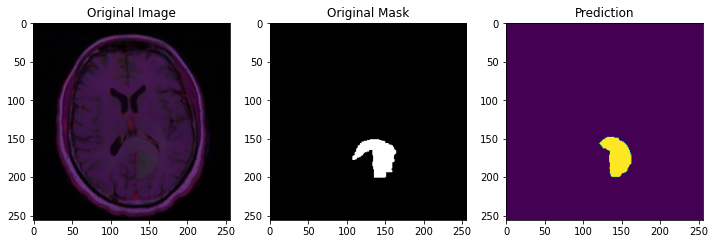

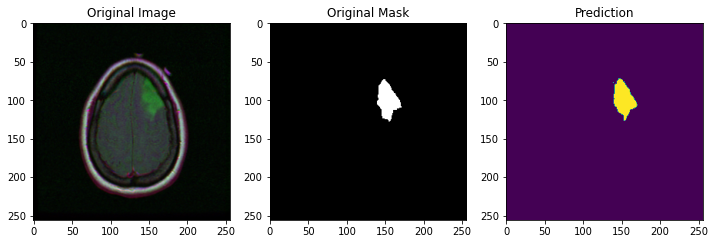

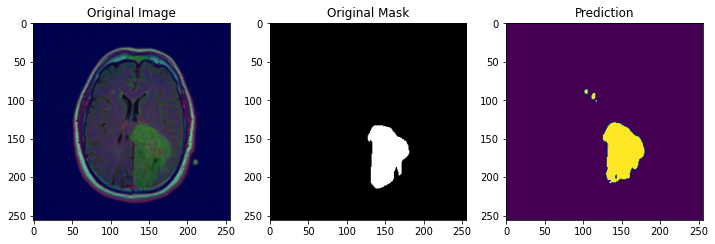

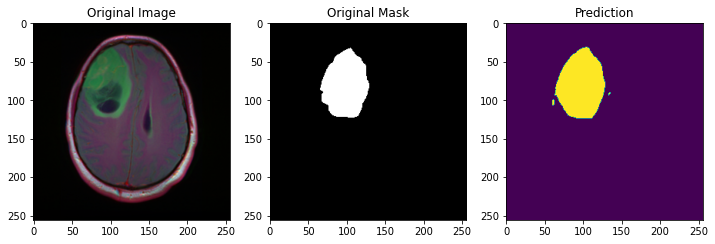

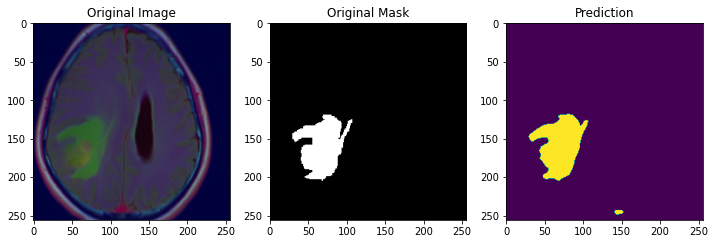

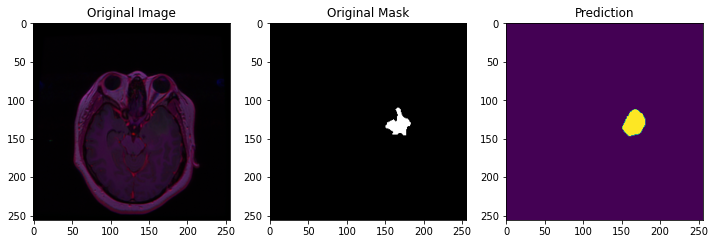

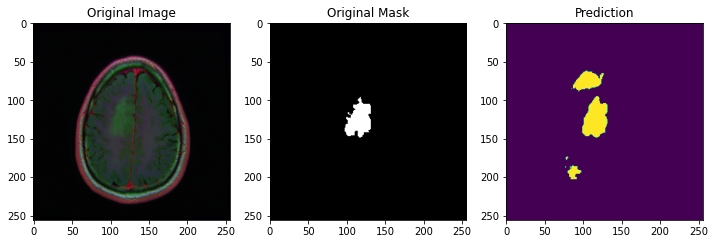

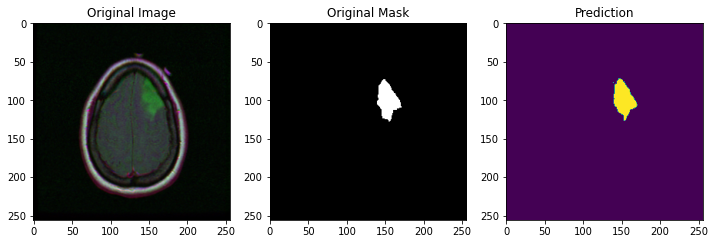

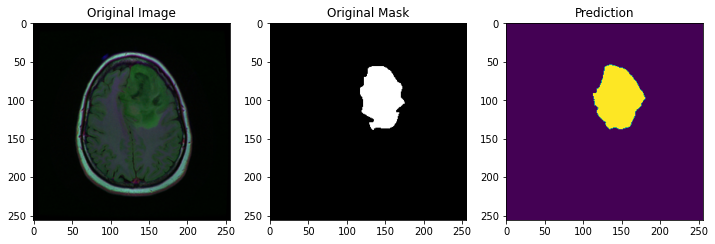

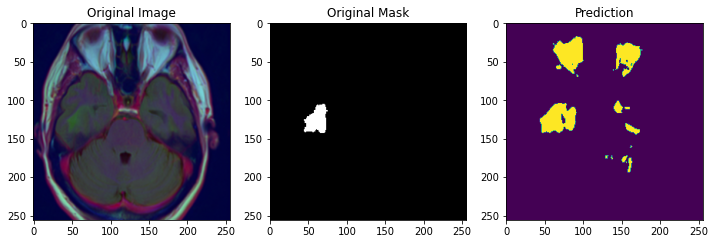

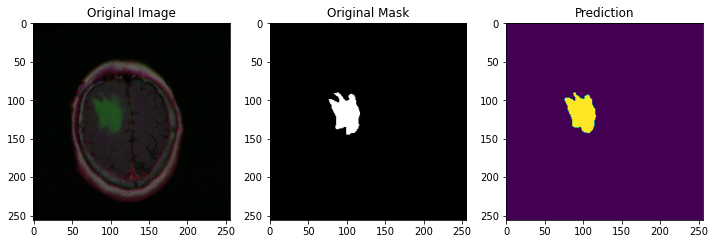

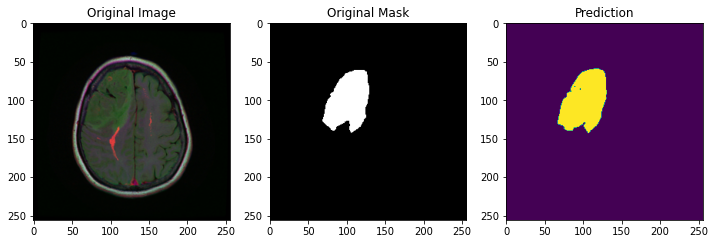

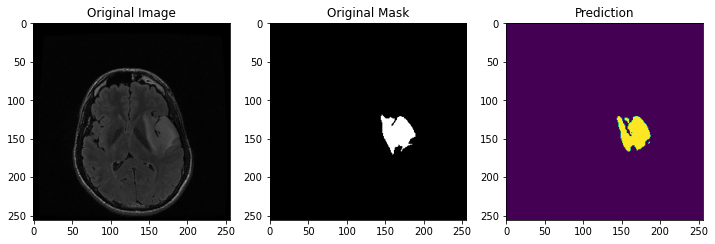

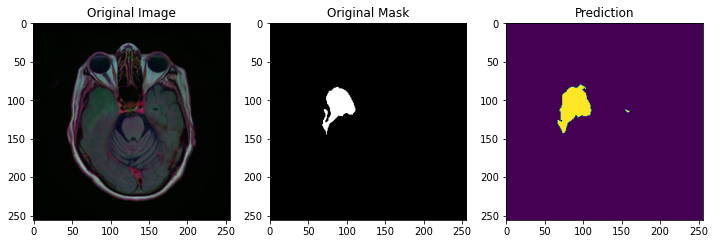

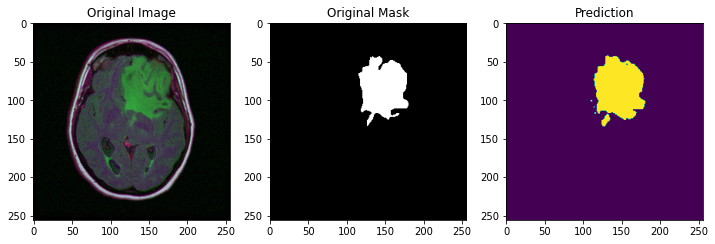

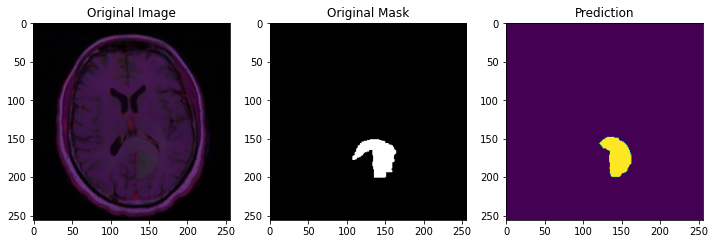

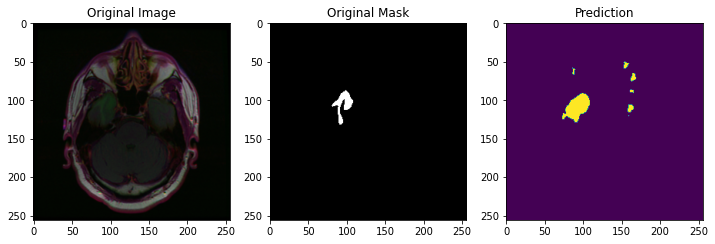

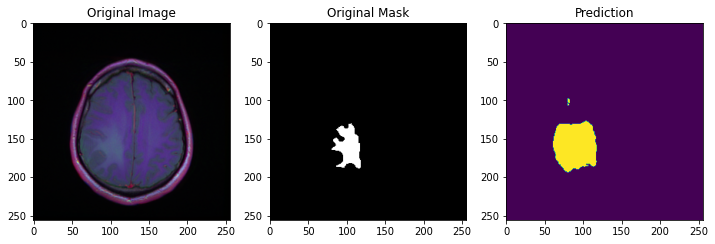

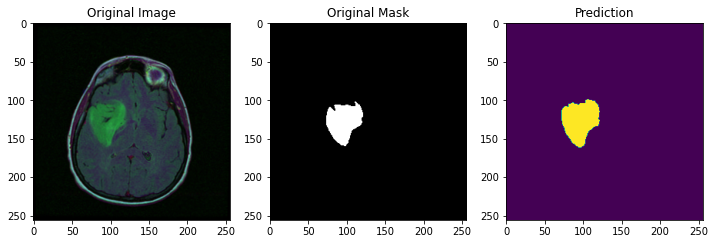

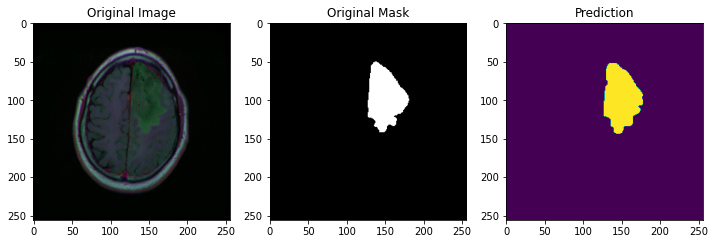

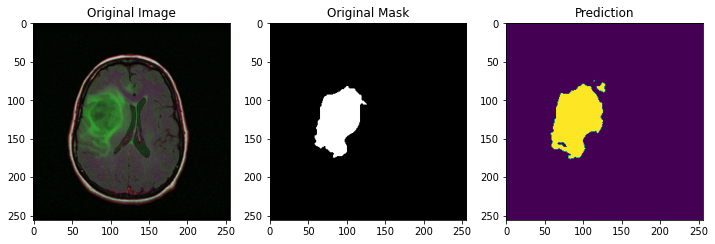

In [ ]:
for i in range(30):
    index=np.random.randint(1,len(X_test.index))
    img = cv2.imread(X_test['image_path'].iloc[index])
    img = cv2.resize(img ,(256, 256))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model_seg.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(X_test['mask_path'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()


In [ ]:
test

In [ ]:
def prediction (model, model_seg, test):
  image_path = test['image_path']
  test['mask'] = test['mask'].apply(lambda x: str(x))
  mask = []
  has_mask = []
  for w in test.index:
    i = test['image_path'][w]
    img = cv2.imread(i)
    img = cv2.resize(img ,(256, 256))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    has_mask_current = np.argmax(model.predict(img))
    has_mask.append(has_mask_current)
    if (has_mask_current == 0):
      mask.append("No mask")      
    else:
      mask.append(model_seg.predict(img))
  return image_path, mask, has_mask


In [ ]:
image_id, mask, has_mask = prediction(model, model_seg, test)

In [ ]:
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred.head()

In [ ]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

In [ ]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and df_pred['mask'][i] == "1" and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI " + str(i))
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

In [ ]:
DATA_DIR = 'lgg-mri-segmentation/'

In [ ]:
from tensorflow import keras
import tensorflow as tf
with open(DATA_DIR + 'ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
model = tf.keras.models.model_from_json(json_savedModel)
model_save_name = 'ResUNet-weights.hdf5'
path = F"lgg-mri-segmentation"
model.load_weights(path)
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
target_img_shape_1             = 256
target_img_shape_2             = 256

predict_path = DATA_DIR + '/predict/'
predict_datagen         = ImageDataGenerator(rescale = 1./255)
predict_generator       = predict_datagen.flow_from_directory(predict_path,target_size = (target_img_shape_1, target_img_shape_2)) 

Found 1 images belonging to 1 classes.


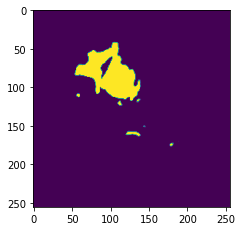

In [ ]:
import matplotlib.pyplot as plt

img = model.predict(predict_generator)
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(img))